In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import ticktack
from ticktack import fitting2 as fitting
from tqdm import tqdm
import scipy

rcParams['figure.figsize'] = (8.0, 4.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_gp.csv')
cf.prepare_function(use_control_points=True, interp='gp')

In [3]:
cf.control_points_time

DeviceArray([210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
             222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
             234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
             246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
             258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
             270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
             282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293,
             294, 295, 296, 297], dtype=int64)

In [4]:
import inspect
print(inspect.getsource(cf.loss_chi2))

    @partial(jit, static_argnums=(0,))
    def loss_chi2(self, params=()):
        d_14_c = self.dc14(params=params)
        chi2 = jnp.sum(((self.d14c_data[:-1] - d_14_c) / self.d14c_data_error[:-1]) ** 2)
        return 0.5*chi2



In [5]:
@jit
def gauss(t):
    prod =  1.87 + 0.2 * 1.87 * jnp.exp(-1/2*((t-250)/10)**2.)
    return prod

In [6]:
cf.offset

DeviceArray(-0.44436304, dtype=float64)

In [7]:
cf.offset = 0
cf.offset

0

In [8]:
%%time
soln = cf.fit_cp(low_bound=0.)

CPU times: user 4min 47s, sys: 2.27 s, total: 4min 50s
Wall time: 4min 27s


In [9]:
soln.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [10]:
print("total likelihood: ", cf.gp_likelihood(soln.x))
print("gp likelihood: ", cf.gp_neg_log_likelihood(soln.x))
print("chi2: ", cf.loss_chi2(soln.x))

total likelihood:  94.5048556092349
gp likelihood:  94.50472569152423
chi2:  0.0001299177106681797


Text(0.5, 1.0, 'gauss production rate')

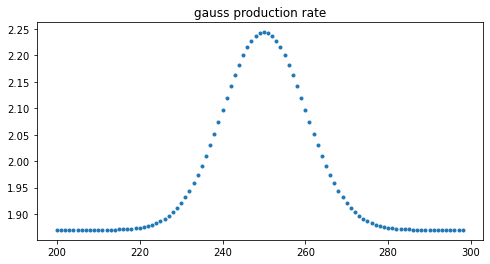

In [19]:
t = cf.annual
true_cp = gauss(t)
plt.plot(t, gauss(t), ".")
plt.title('gauss production rate')

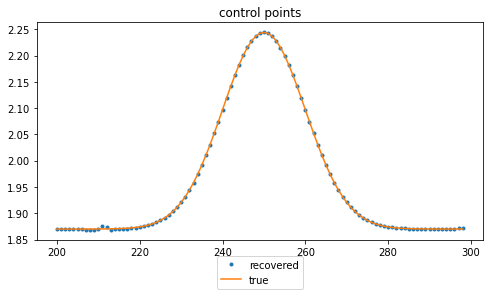

In [22]:
plt.plot(t, cf.production(t, (soln.x,)), ".", label="recovered")
plt.plot(t, true_cp, label='true')
plt.title("control points");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

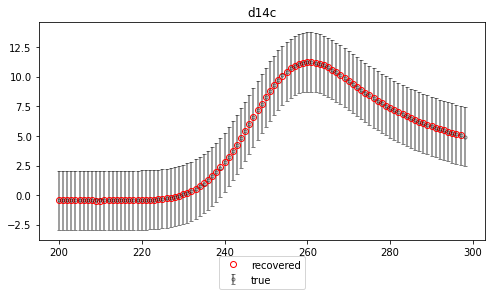

In [29]:
plt.plot(cf.time_data[:-1], cf.dc14(soln.x), "or", fillstyle="none", label="recovered")
# plt.plot(cf.time_data, cf.d14c_data, '--r')
plt.errorbar(cf.time_data, cf.d14c_data, yerr=cf.d14c_data_error, fmt='.k', fillstyle="none", capsize=2, 
             label="true", alpha=0.5)
plt.title("d14c");
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True)

In [28]:
cf.dc14(soln.x) - cf.d14c_data[:-1]

DeviceArray([ 6.38162132e-03,  6.34037456e-03,  6.25041011e-03,
              6.06508144e-03,  5.69281161e-03,  4.96469350e-03,
              3.59510320e-03,  1.17833307e-03, -2.60487635e-03,
             -6.98696428e-03, -7.00783229e-03,  3.03458782e-03,
              1.31801386e-02,  1.41252790e-02,  1.09715266e-02,
              6.67321498e-03,  2.26916195e-03, -1.20417894e-03,
             -3.46542359e-03, -4.55530736e-03, -4.68232978e-03,
             -4.15496014e-03, -3.25101532e-03, -2.17623850e-03,
             -1.07428086e-03, -4.84999169e-05,  8.17394132e-04,
              1.51749264e-03,  2.06701189e-03,  2.48071500e-03,
              2.76053640e-03,  2.93585863e-03,  3.03219498e-03,
              3.05925370e-03,  3.03363134e-03,  2.98169332e-03,
              2.89667876e-03,  2.76827870e-03,  2.61109725e-03,
              2.41803479e-03,  2.18552345e-03,  1.92704387e-03,
              1.65536348e-03,  1.35889506e-03,  1.00744503e-03,
              6.09584663e-04,  1.9615851

In [23]:
t = np.arange(cf.start-10, cf.start+20, 0.1)

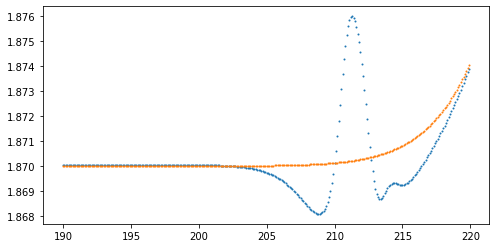

In [24]:
mu = cf.production(t, (soln.x,))
plt.plot(t, mu, ".", markersize=2)
plt.plot(t, gauss(t), ".", markersize=2)

In [25]:
soln.x

array([1.87010557, 1.87561389, 1.87410361, 1.86908268, 1.86919508,
       1.86924075, 1.86969006, 1.8705274 , 1.87151317, 1.87267531,
       1.8740373 , 1.87563661, 1.87758355, 1.87999359, 1.88298623,
       1.88668749, 1.89121703, 1.89675756, 1.90343672, 1.9113952 ,
       1.92074758, 1.93163097, 1.94412116, 1.95826445, 1.97407481,
       1.99151606, 2.01045971, 2.03074015, 2.05213647, 2.07431916,
       2.09692609, 2.11953629, 2.14167473, 2.16282599, 2.18246675,
       2.20011839, 2.21531495, 2.22759778, 2.23663858, 2.24215905,
       2.24401652, 2.24212958, 2.23656474, 2.22750141, 2.21519068,
       2.19998758, 2.18231559, 2.16264018, 2.14149685, 2.11936611,
       2.09676684, 2.07416817, 2.05201518, 2.03064401, 2.01037762,
       1.99145362, 1.97405269, 1.95827113, 1.94414563, 1.9316658 ,
       1.92079171, 1.91142384, 1.90343688, 1.89673224, 1.89116644,
       1.88659125, 1.88286123, 1.87986565, 1.87750221, 1.87564207,
       1.87419035, 1.87307975, 1.87224452, 1.87162459, 1.87116